In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

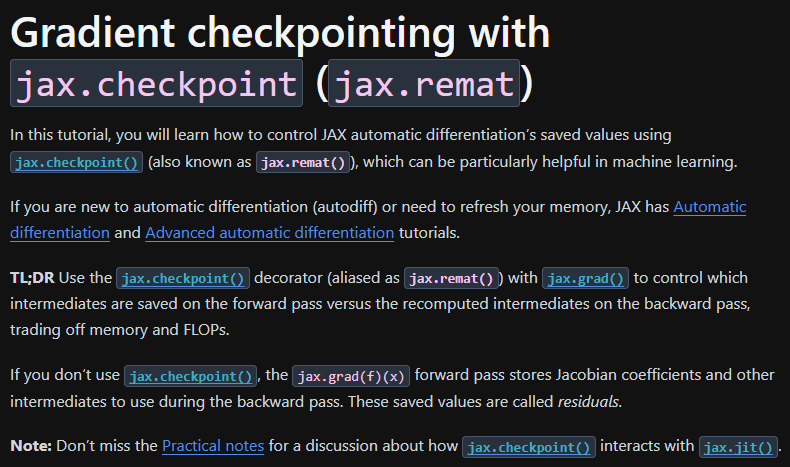

In [2]:
import jax
import jax.numpy as jnp

def g(W, x):
  y = jnp.dot(W, x)
  return jnp.sin(y)

def f(W1, W2, W3, x):
  x = g(W1, x)
  x = g(W2, x)
  x = g(W3, x)
  return x

W1 = jnp.ones((5, 4))
W2 = jnp.ones((6, 5))
W3 = jnp.ones((7, 6))
x = jnp.ones(4)

# Inspect the 'residual' values to be saved on the forward pass
# if you were to evaluate `jax.grad(f)(W1, W2, W3, x)`
from jax.ad_checkpoint import print_saved_residuals
jax.ad_checkpoint.print_saved_residuals(f, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)
f32[5] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)
f32[6] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)
f32[6] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)
f32[7] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)


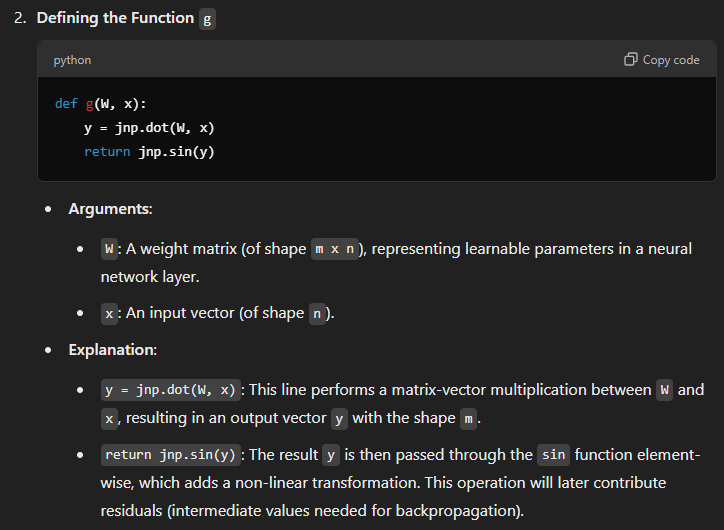

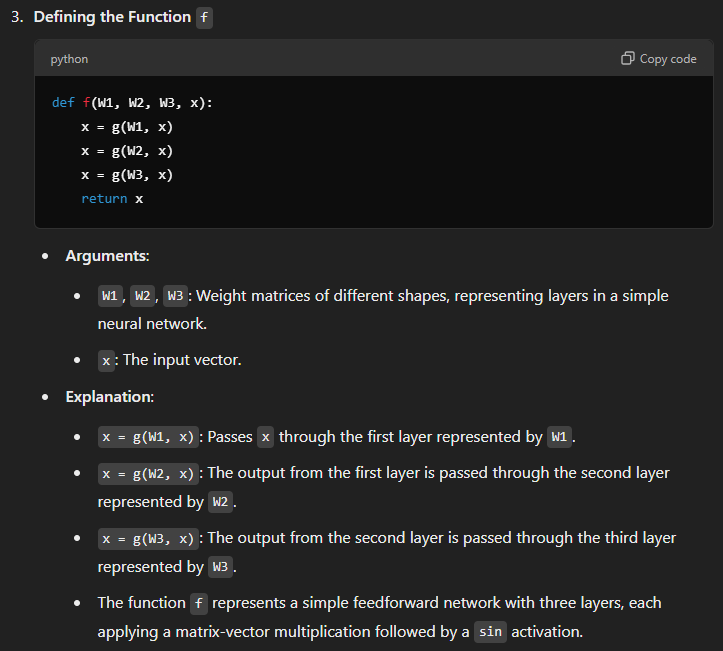

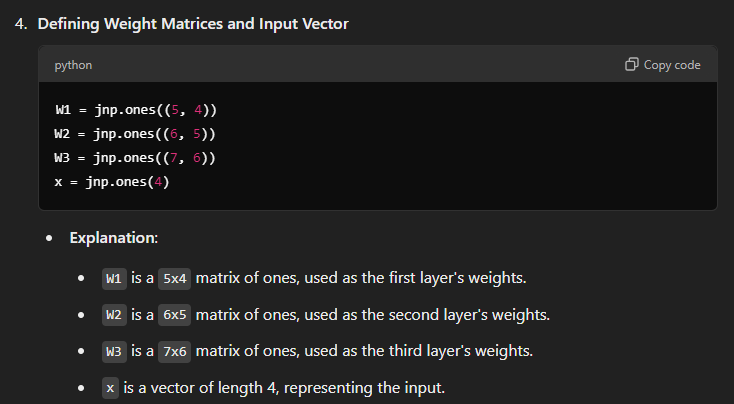

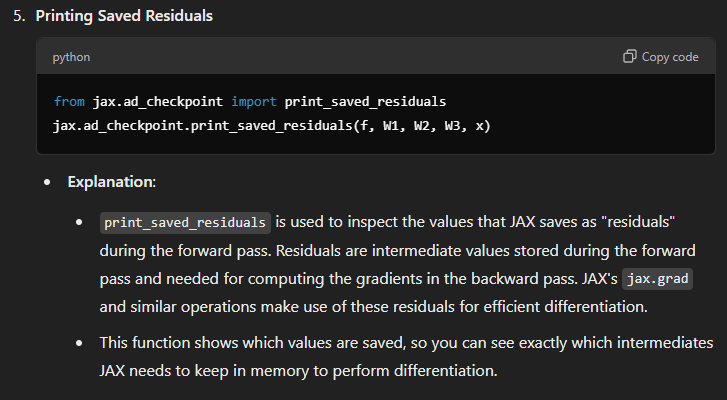

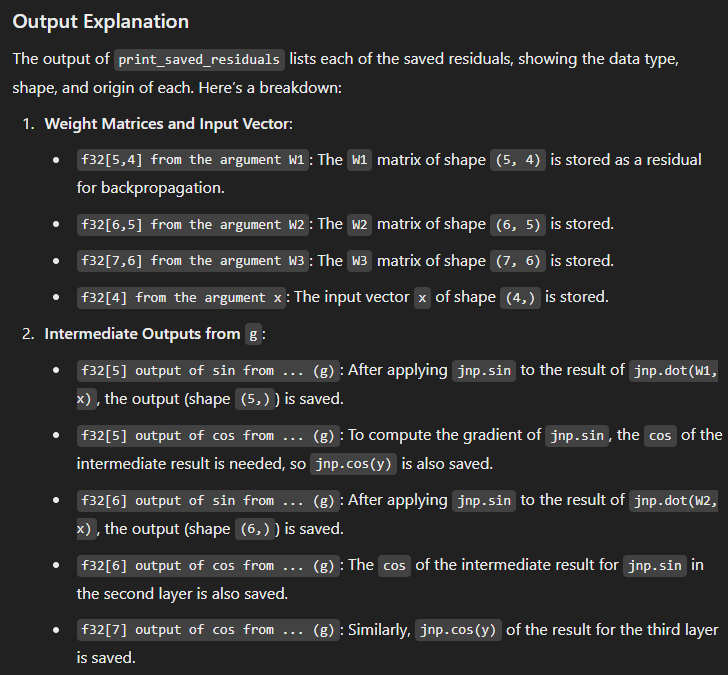

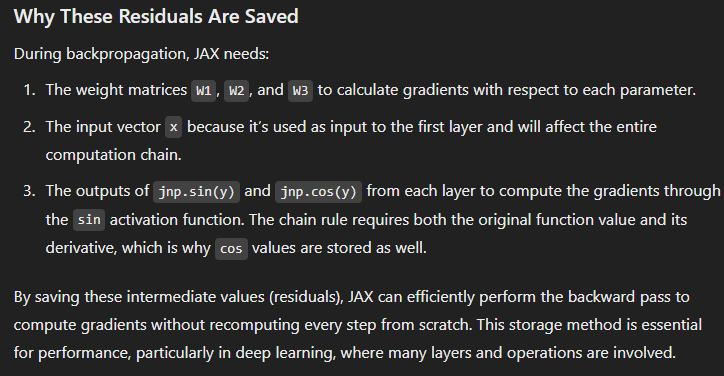

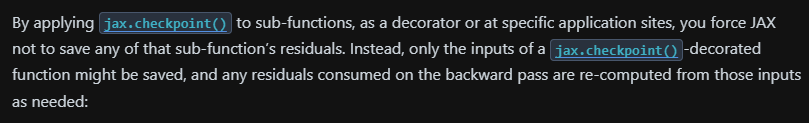

In [3]:
def f2(W1, W2, W3, x):
  x = jax.checkpoint(g)(W1, x)
  x = jax.checkpoint(g)(W2, x)
  x = jax.checkpoint(g)(W3, x)
  return x

jax.ad_checkpoint.print_saved_residuals(f2, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)
f32[6] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:6:9 (g)


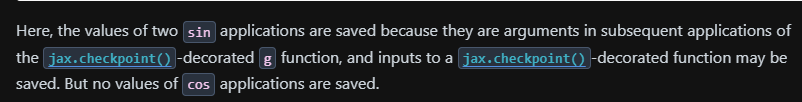

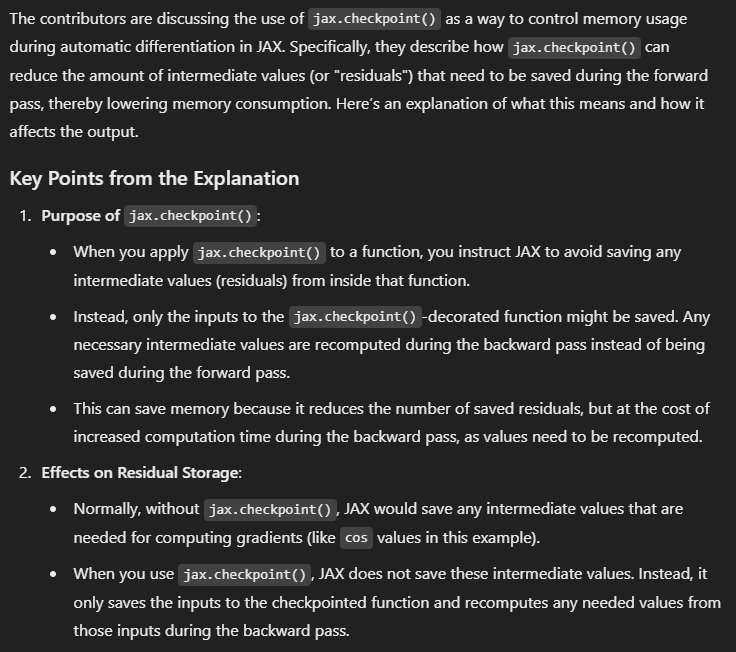

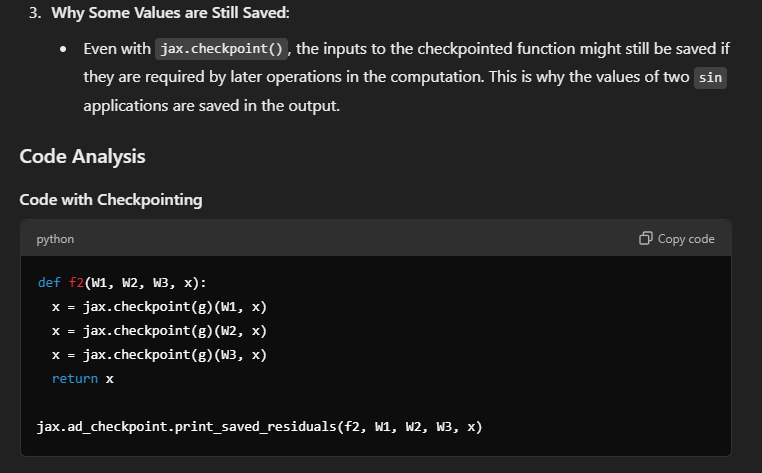

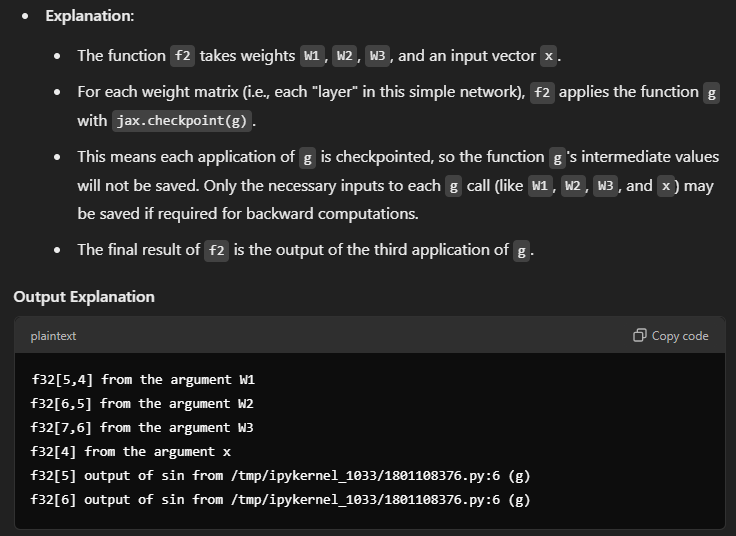

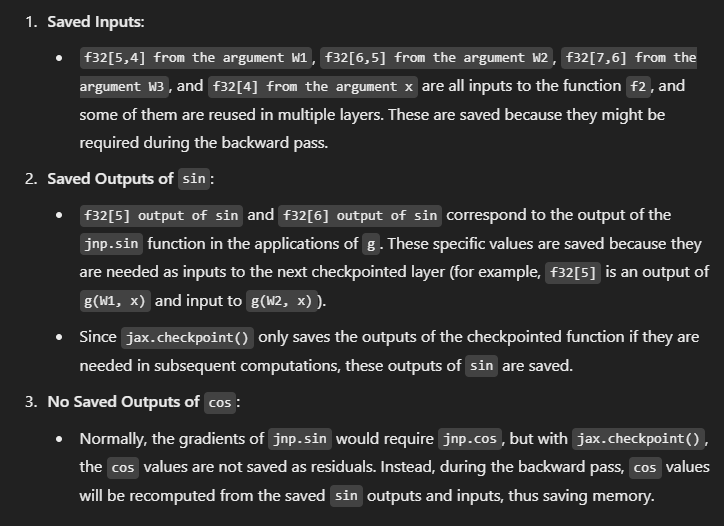

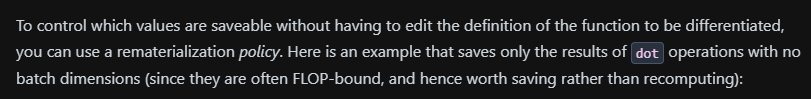

In [4]:
f3 = jax.checkpoint(f, policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
jax.ad_checkpoint.print_saved_residuals(f3, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:5:6 (g)
f32[6] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:5:6 (g)
f32[7] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1801108376.py:5:6 (g)


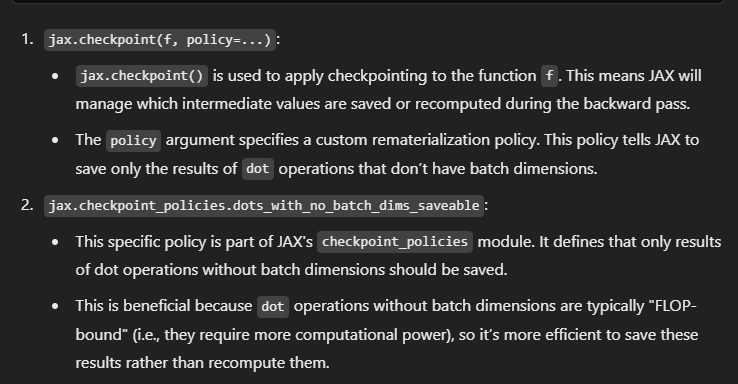

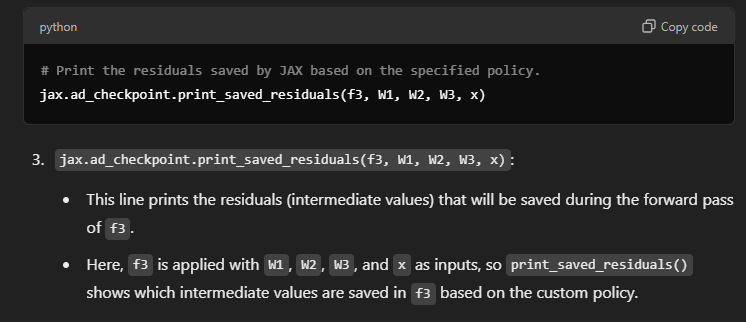

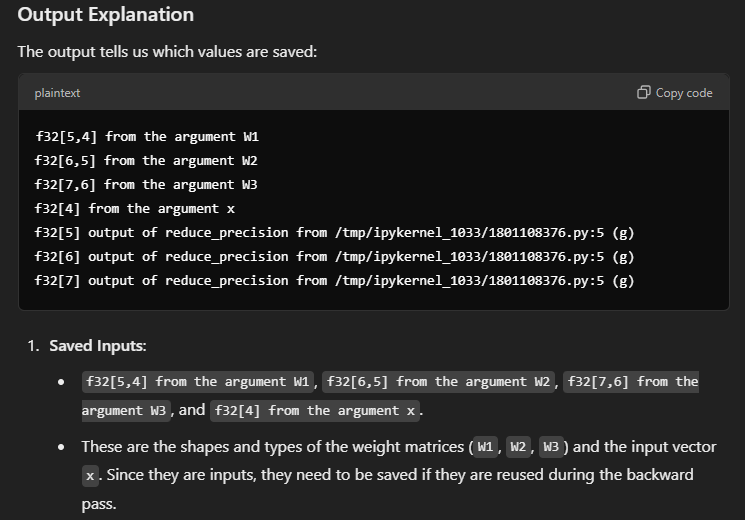

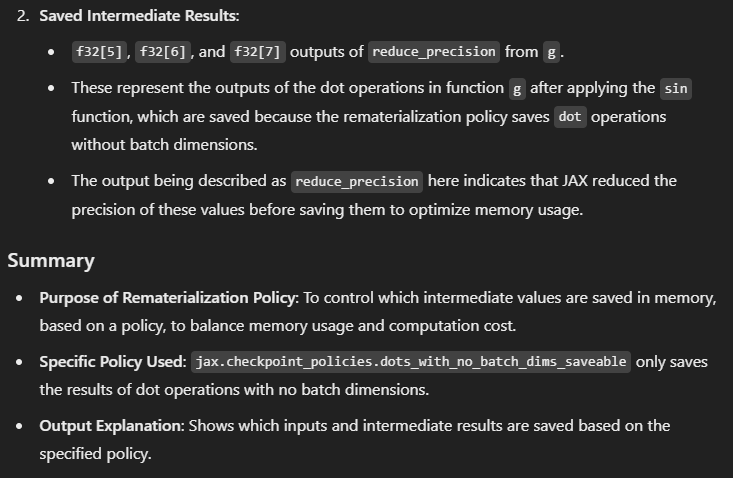

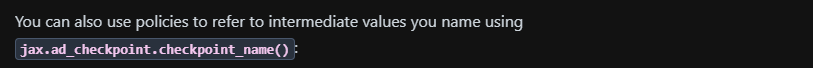

In [5]:
from jax.ad_checkpoint import checkpoint_name

def f4(W1, W2, W3, x):
  x = checkpoint_name(g(W1, x), name='a')
  x = checkpoint_name(g(W2, x), name='b')
  x = checkpoint_name(g(W3, x), name='c')
  return x

f4 = jax.checkpoint(f4, policy=jax.checkpoint_policies.save_only_these_names('a'))
jax.ad_checkpoint.print_saved_residuals(f4, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] named 'a' from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\2296542172.py:4:6 (f4)


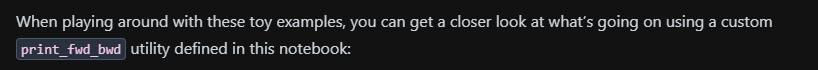

In [6]:
from jax.tree_util import tree_flatten, tree_unflatten

from rich.console import Console
from rich.table import Table
import rich.text

def print_fwd_bwd(f, *args, **kwargs) -> None:
  args, in_tree = tree_flatten((args, kwargs))

  def f_(*args):
    args, kwargs = tree_unflatten(in_tree, args)
    return f(*args, **kwargs)

  fwd = jax.make_jaxpr(lambda *args: jax.vjp(f_, *args))(*args).jaxpr

  y, f_vjp = jax.vjp(f_, *args)
  res, in_tree = tree_flatten(f_vjp)

  def g_(*args):
    *res, y = args
    f_vjp = tree_unflatten(in_tree, res)
    return f_vjp(y)

  bwd = jax.make_jaxpr(g_)(*res, y).jaxpr

  table = Table(show_header=False, show_lines=True, padding=(1, 2, 0, 2), box=None)
  table.add_row("[bold green]forward computation:",
                "[bold green]backward computation:")
  table.add_row(rich.text.Text.from_ansi(str(fwd)),
                rich.text.Text.from_ansi(str(bwd)))
  console = Console(width=240, force_jupyter=True)
  console.print(table)

def _renderable_repr(self):
  return self.html
rich.jupyter.JupyterRenderable._repr_html_ = _renderable_repr

In [7]:
# Without using `jax.checkpoint`:
print_fwd_bwd(f, W1, W2, W3, x)

forward computation:                                         backward computation:                                                                     
                                                                                                                                                         
  { lambda ; a:f32[5,4] b:f32[6,5] c:f32[7,6] d:f32[4]. let    { lambda ; a:f32[4] b:f32[5,4] c:f32[5] d:f32[5] e:f32[6,5] f:f32[6] g:f32[6] h:f32[7,6]  
      e:f32[5] = dot_general[                                      i:f32[7] j:f32[7]. let                                                                
        dimension_numbers=(([1], [0]), ([], []))                   k:f32[7] = mul j i                                                                    
        preferred_element_type=float32                             l:f32[6] = dot_general[                                                               
      ] a d                                                          dimension_numbers=(([0], [0]), ([], []))                                            
      f:f32[5] = sin e                                               preferred_element_type=float32                                                      
      g:f32[5] = cos e                                             ] k h                                                                                 
      h:f32[6] = dot_general[                                      m:f32[7,6] = dot_general[                                                             
        dimension_numbers=(([1], [0]), ([], []))                     dimension_numbers=(([], []), ([], []))                                              
        preferred_element_type=float32                               preferred_element_type=float32                                                      
      ] b f                                                        ] k g                                                                                 
      i:f32[6] = sin h                                             n:f32[6] = mul l f                                                                    
      j:f32[6] = cos h                                             o:f32[5] = dot_general[                                                               
      k:f32[7] = dot_general[                                        dimension_numbers=(([0], [0]), ([], []))                                            
        dimension_numbers=(([1], [0]), ([], []))                     preferred_element_type=float32                                                      
        preferred_element_type=float32                             ] n e                                                                                 
      ] c i                                                        p:f32[6,5] = dot_general[                                                             
      l:f32[7] = sin k                                               dimension_numbers=(([], []), ([], []))                                              
      m:f32[7] = cos k                                               preferred_element_type=float32                                                      
    in (l, d, a, g, f, b, j, i, c, m) }                            ] n d                                                                                 
                                                                   q:f32[5] = mul o c                                                                    
                                                                   r:f32[4] = dot_general[                                                               
                                                                     dimension_numbers=(([0], [0]), ([], []))                                            
                                                                     preferred_element_type=float32                                                     

In [8]:
# Using `jax.checkpoint` with policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable:
print_fwd_bwd(f3, W1, W2, W3, x)

forward computation:                                         backward computation:                                                                          
                                                                                                                                                              
  { lambda ; a:f32[5,4] b:f32[6,5] c:f32[7,6] d:f32[4]. let    { lambda ; a:f32[5] b:f32[6] c:f32[7] d:f32[5,4] e:f32[6,5] f:f32[7,6] g:f32[4] h:f32[7]. let  
      e:f32[5] = dot_general[                                      i:f32[5,4] j:f32[6,5] k:f32[7,6] l:f32[4] = remat2[                                        
        dimension_numbers=(([1], [0]), ([], []))                     differentiated=True                                                                      
        preferred_element_type=float32                               jaxpr={ lambda ; m:f32[5] n:f32[6] o:f32[7] p:f32[5,4] q:f32[6,5] r:f32[7,6]             
      ] a d                                                              s:f32[4] t:f32[7]. let                                                               
      f:f32[5] = sin e                                                   u:f32[5] = sin m                                                                     
      g:f32[6] = dot_general[                                            v:f32[5] = cos m                                                                     
        dimension_numbers=(([1], [0]), ([], []))                         w:f32[6] = sin n                                                                     
        preferred_element_type=float32                                   x:f32[6] = cos n                                                                     
      ] b f                                                              y:f32[7] = cos o                                                                     
      h:f32[6] = sin g                                                   z:f32[7] = mul t y                                                                   
      i:f32[7] = dot_general[                                            ba:f32[6] = dot_general[                                                             
        dimension_numbers=(([1], [0]), ([], []))                           dimension_numbers=(([0], [0]), ([], []))                                           
        preferred_element_type=float32                                     preferred_element_type=float32                                                     
      ] c h                                                              ] z r                                                                                
      j:f32[7] = sin i                                                   bb:f32[6] = mul ba x                                                                 
    in (j, e, g, i, a, b, c, d) }                                        bc:f32[5] = dot_general[                                                             
                                                                           dimension_numbers=(([0], [0]), ([], []))                                           
                                                                           preferred_element_type=float32                                                     
                                                                         ] bb q                                                                               
                                                                         bd:f32[5] = mul bc v                                                                 
                                                                         be:f32[4] = dot_general[                                                             
                                                                           dimension_numbers=(([0], [0]), ([], []))                                           
                           

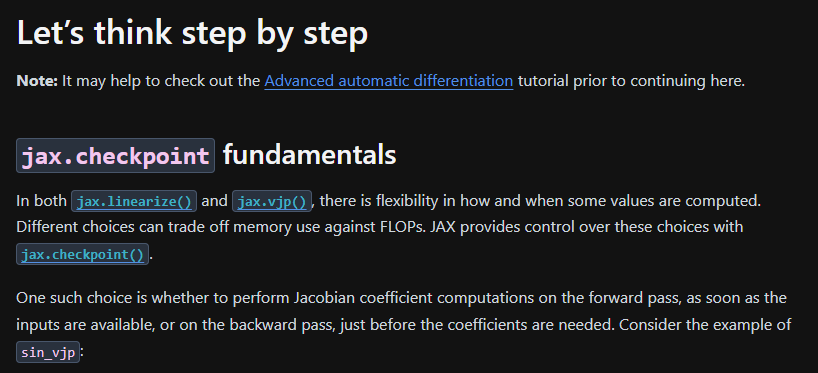

In [9]:
def sin_vjp(x):
  y = jnp.sin(x)
  cos_x = jnp.cos(x)
  return y, lambda y_bar: cos_x * y_bar

In [10]:
def sin_vjp2(x):
  y = jnp.sin(x)
  return y, lambda y_bar: jnp.cos(x) * y_bar

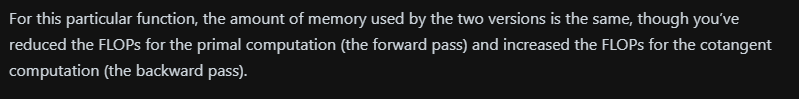

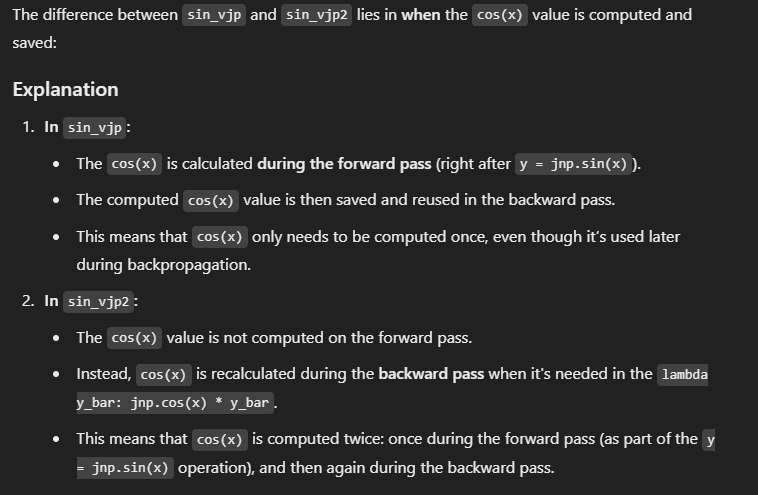

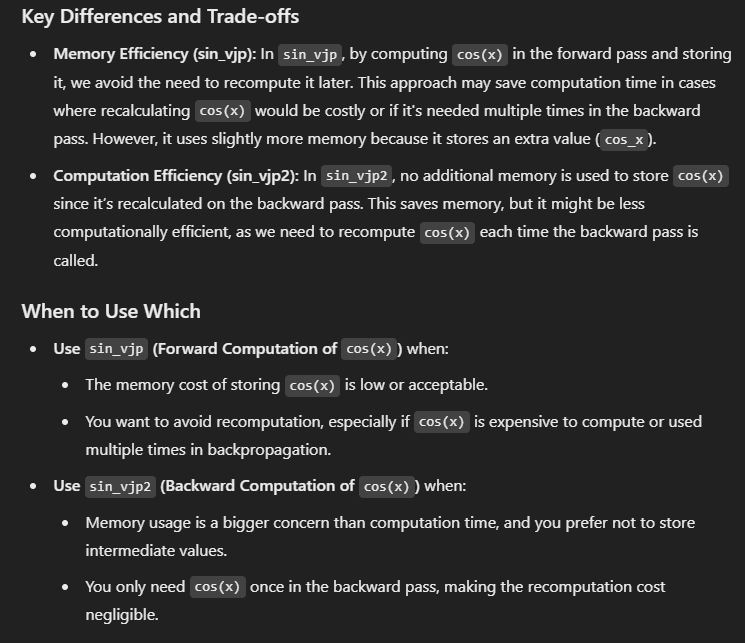

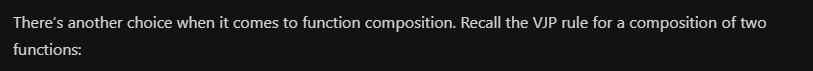

In [11]:
def f(x):
  y = g(x)
  z = h(y)
  return z

def f_vjp(x):
  y, g_vjp = jax.vjp(g, x)
  z, h_vjp = jax.vjp(h, y)
  def f_bwd(z_bar):
    y_bar, = h_vjp(z_bar)
    x_bar, = g_vjp(y_bar)
    return x_bar
  return z, f_bwd

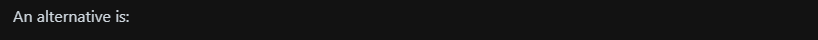

In [12]:
def f_vjp_checkpoint(x):
  y = g(x)
  z, h_vjp = jax.vjp(h, y)
  def f_bwd2(z_bar):
    y_bar, = h_vjp(z_bar)
    _, g_vjp = jax.vjp(g, x)
    x_bar, = g_vjp(y_bar)
    return x_bar
  return z, f_bwd2

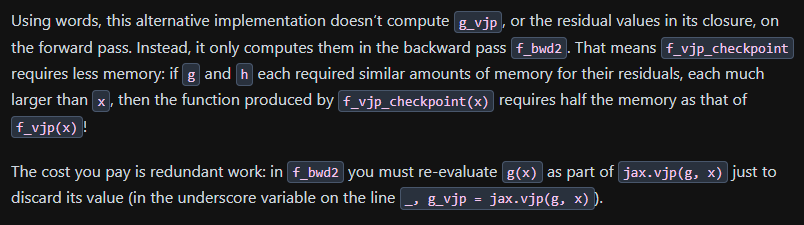

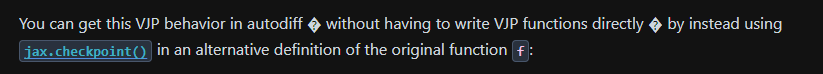

In [13]:
def f_checkpoint(x):
  y = jax.checkpoint(g)(x)
  z = h(y)
  return z

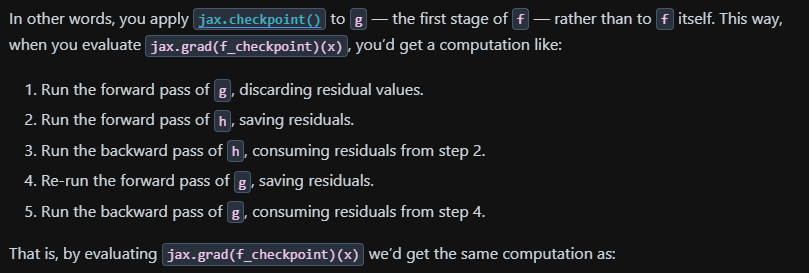

In [14]:
def f_checkpoint_grad(x):
  y = g(x)                  # step 1
  _, h_vjp = jax.vjp(h)(y)  # step 2
  y_bar, = h_vjp(1.0)       # step 3
  _, g_vjp = jax.vjp(g, x)  # step 4
  x_bar, = g_vjp(y_bar)     # step 5
  return x_bar

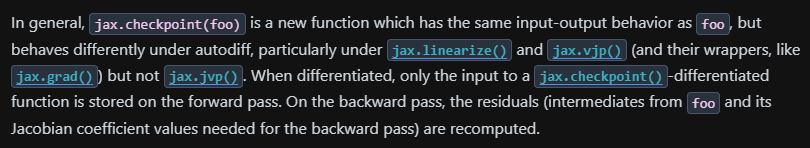

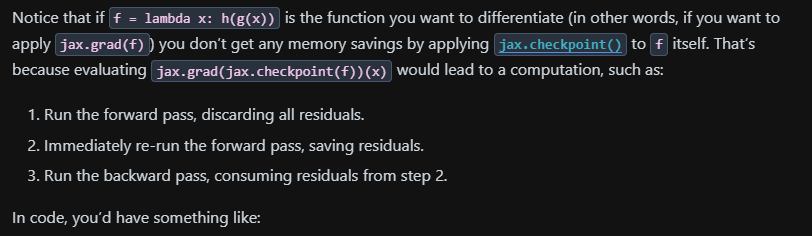

In [15]:
def f_grad_bad(x):
  _ = f(x)                  # step 1
  _, f_vjp = jax.vjp(f, x)  # step 2
  x_bar, = f_vjp(1.0)       # step 3
  return x_bar

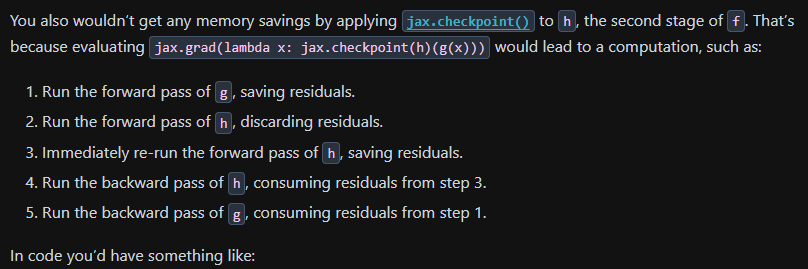

In [16]:
def f_grad_bad2(x):
  y, g_vjp = jax.vjp(g, x)  # step 1
  z = h(y)                  # step 2
  _, h_vjp = jax.vjp(h, y)  # step 3
  y_bar, = h_vjp(1.0)       # step 3
  x_bar, = g_vjp(y_bar)     # step 5
  return x_bar

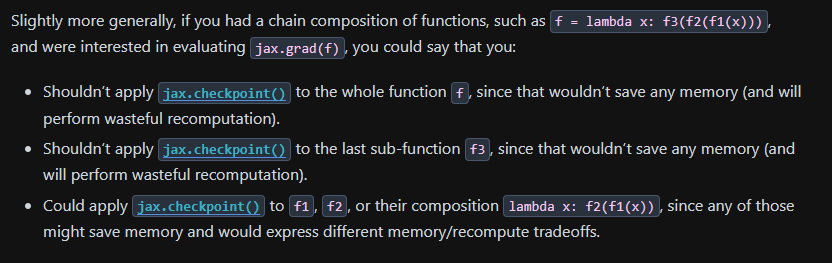

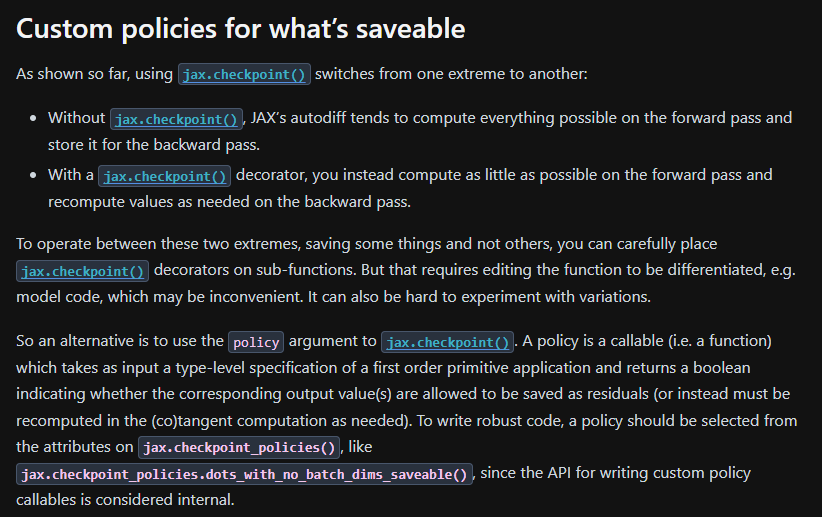

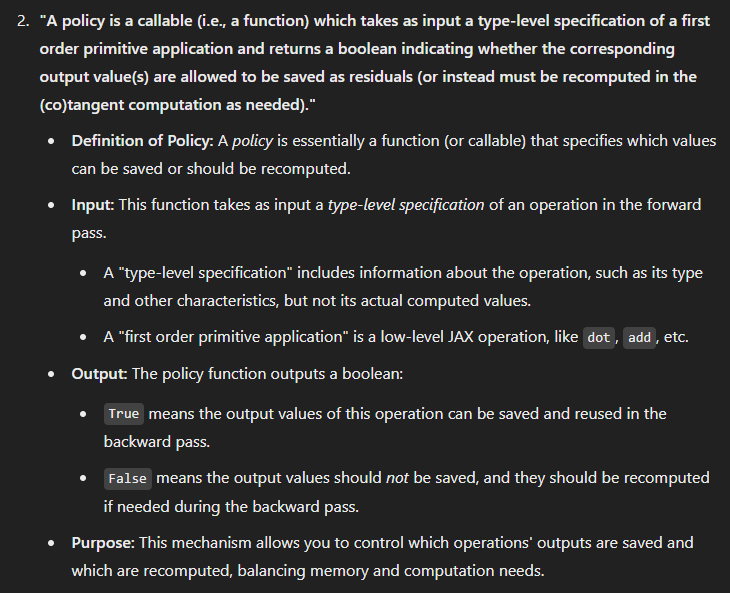

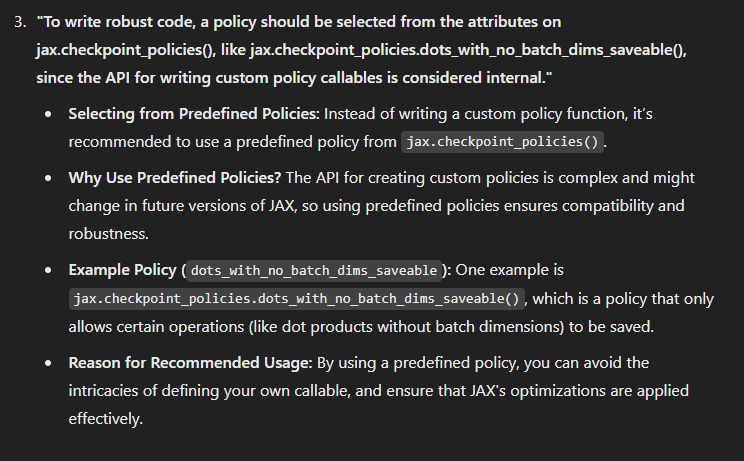

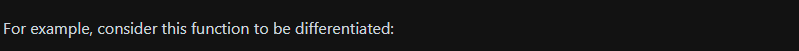

In [17]:
def loss(params, x, y):
  return jnp.sum((predict(params, x) - y)**2)

def predict(params, x):
  *Ws, Wlast = params
  for W in Ws:
    x = layer(W, x)
  x = jnp.dot(Wlast, x)
  return x

def layer(W, x):
  return jnp.sin(jnp.dot(W, x))

In [18]:
W1 = W2 = W3 = jnp.ones((4, 4))
params = [W1, W2, W3]
x = jnp.ones(4)
y = jnp.ones(4)

In [19]:
print_saved_residuals(loss, params, x, y)

f32[4,4] from the argument params[0]
f32[4,4] from the argument params[1]
f32[4,4] from the argument params[2]
f32[4] from the argument x
f32[4] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] output of mul from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:2:17 (loss)


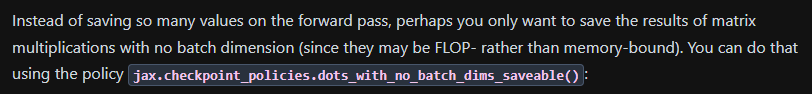

In [20]:
loss_checkpoint = jax.checkpoint(loss, policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
print_saved_residuals(loss_checkpoint, params, x, y)

f32[4,4] from the argument params[0]
f32[4,4] from the argument params[1]
f32[4,4] from the argument params[2]
f32[4] from the argument x
f32[4] from the argument y
f32[4] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:17 (layer)
f32[4] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:17 (layer)
f32[4] output of dot_general from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:8:6 (predict)


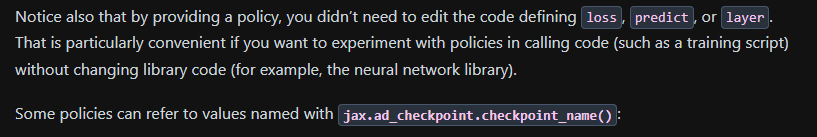

In [21]:
from jax.ad_checkpoint import checkpoint_name

def predict(params, x):
  *Ws, Wlast = params
  for i, W in enumerate(Ws):
    x = layer(W, x)
    x = checkpoint_name(x, name=f'layer{i}_output')
  x = jnp.dot(Wlast, x)
  return x

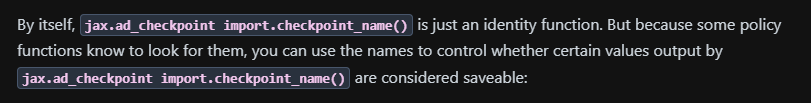

In [22]:
print_saved_residuals(loss, params, x, y)

f32[4,4] from the argument params[0]
f32[4,4] from the argument params[1]
f32[4,4] from the argument params[2]
f32[4] from the argument x
f32[4] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] named 'layer0_output' from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\178264713.py:7:8 (predict)
f32[4] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:12:9 (layer)
f32[4] named 'layer1_output' from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\178264713.py:7:8 (predict)
f32[4] output of mul from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\4230705069.py:2:17 (loss)


In [23]:
loss_checkpoint2 = jax.checkpoint(loss, policy=jax.checkpoint_policies.save_any_names_but_these('layer1_output'))
print_saved_residuals(loss_checkpoint2, params, x, y)

f32[4,4] from the argument params[0]
f32[4,4] from the argument params[1]
f32[4,4] from the argument params[2]
f32[4] from the argument x
f32[4] from the argument y


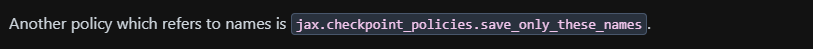

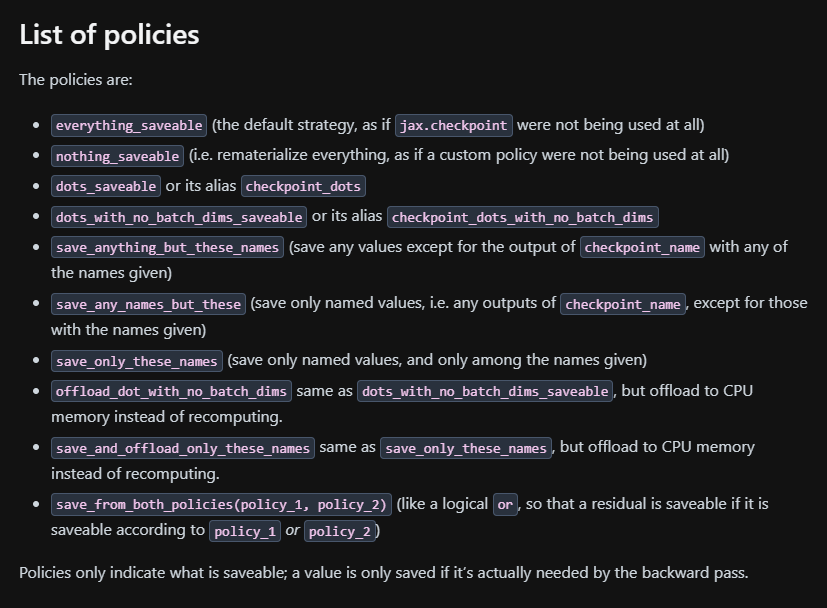

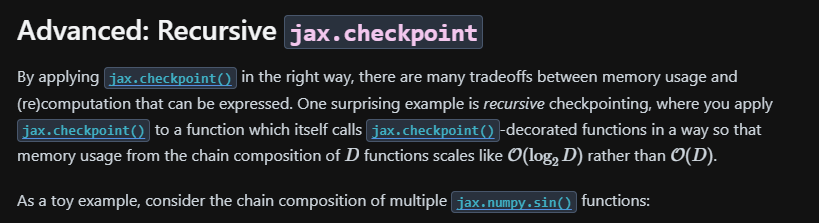

In [24]:
def chain_compose(funs):
  def f(x):
    for fun in funs:
      x = fun(x)
    return x
  return f

f = chain_compose([jnp.sin] * 8)
print_saved_residuals(f, 3.)

f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)


In [26]:
[jnp.sin(3)]*8

[Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True),
 Array(0.14112, dtype=float32, weak_type=True)]

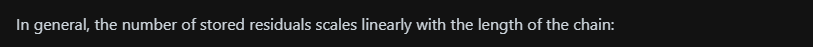

In [27]:
f = chain_compose([jnp.sin] * 16)
print_saved_residuals(f, 3.)

f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\410288286.py:4:10 (chain_compose.<locals>.f)
f32[] output of cos from C:\Users\haadi\

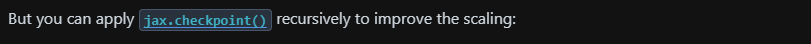

In [28]:
def recursive_checkpoint(funs):
  if len(funs) == 1:
    return funs[0]
  elif len(funs) == 2:
    f1, f2 = funs
    return lambda x: f1(f2(x))
  else:
    f1 = recursive_checkpoint(funs[:len(funs)//2])
    f2 = recursive_checkpoint(funs[len(funs)//2:])
    return lambda x: f1(jax.checkpoint(f2)(x))

In [29]:
f = recursive_checkpoint([jnp.sin] * 8)
print_saved_residuals(f, 3.)

f32[] from the argument x
f32[] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:21 (recursive_checkpoint.<locals>.<lambda>)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:24 (recursive_checkpoint.<locals>.<lambda>)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:21 (recursive_checkpoint.<locals>.<lambda>)


In [30]:
f = recursive_checkpoint([jnp.sin] * 16)
print_saved_residuals(f, 3.)

f32[] from the argument x
f32[] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:21 (recursive_checkpoint.<locals>.<lambda>)
f32[] output of sin from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:21 (recursive_checkpoint.<locals>.<lambda>)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:24 (recursive_checkpoint.<locals>.<lambda>)
f32[] output of cos from C:\Users\haadi\AppData\Local\Temp\ipykernel_37912\1943107544.py:6:21 (recursive_checkpoint.<locals>.<lambda>)


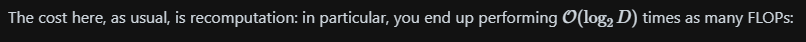

In [31]:
f = chain_compose([jnp.sin] * 8)
print_fwd_bwd(f, 3.)

forward computation:                  backward computation:                                                                    
                                                                                                                                 
  { lambda ; a:f32[]. let               { lambda ; a:f32[] b:f32[] c:f32[] d:f32[] e:f32[] f:f32[] g:f32[] h:f32[] i:f32[]. let  
      b:f32[] = sin a                       j:f32[] = mul i h                                                                    
      c:f32[] = cos a                       k:f32[] = mul j g                                                                    
      d:f32[] = sin b                       l:f32[] = mul k f                                                                    
      e:f32[] = cos b                       m:f32[] = mul l e                                                                    
      f:f32[] = sin d                       n:f32[] = mul m d                                                                    
      g:f32[] = cos d                       o:f32[] = mul n c                                                                    
      h:f32[] = sin f                       p:f32[] = mul o b                                                                    
      i:f32[] = cos f                       q:f32[] = mul p a                                                                    
      j:f32[] = sin h                     in (q,) }                                                                              
      k:f32[] = cos h                                                                                                            
      l:f32[] = sin j                                                                                                            
      m:f32[] = cos j                                                                                                            
      n:f32[] = sin l                                                                                                            
      o:f32[] = cos l                                                                                                            
      p:f32[] = sin n                                                                                                            
      q:f32[] = cos n                                                                                                            
    in (p, c, e, g, i, k, m, o, q) }

In [32]:
f = recursive_checkpoint([jnp.sin] * 8)
print_fwd_bwd(f, 3.)

forward computation:                                                              backward computation:                               
                                                                                                                                        
  { lambda ; a:f32[]. let                                                           { lambda ; a:f32[] b:f32[] c:f32[] d:f32[]. let     
      b:f32[] = remat2[                                                                 e:f32[] = mul d c                               
        differentiated=False                                                            f:f32[] = mul e b                               
        jaxpr={ lambda ; c:f32[]. let d:f32[] = sin c; e:f32[] = sin d in (e,) }        g:f32[] = remat2[                               
        policy=None                                                                       differentiated=True                           
        prevent_cse=True                                                                  jaxpr={ lambda ; h:f32[] i:f32[]. let         
      ] a                                                                                     j:f32[] = sin h                           
      f:f32[] = sin b                                                                         k:f32[] = cos h                           
      g:f32[] = sin f                                                                         l:f32[] = cos j                           
      h:f32[] = sin g                                                                         m:f32[] = mul i l                         
      i:f32[] = sin h                                                                         n:f32[] = mul m k                         
      j:f32[] = sin i                                                                       in (n,) }                                   
      k:f32[] = cos i                                                                     policy=None                                   
      l:f32[] = sin j                                                                     prevent_cse=True                              
      m:f32[] = cos j                                                                   ] a f                                           
    in (l, g, a, k, m) }                                                                o:f32[] = remat2[                               
                                                                                          differentiated=True                           
                                                                                          jaxpr={ lambda ; p:f32[] q:f32[]. let         
                                                                                              r:f32[] = sin p                           
                                                                                              s:f32[] = sin r                           
                                                                                              t:f32[] = sin s                           
                                                                                              u:f32[] = cos s                           
                                                                                              v:f32[] = cos t                           
                                                                                              w:f32[] = mul q v                         
                                                                                              x:f32[] = mul w u                         
                                                                                              y:f32[] = remat2[                         
                                                                                                differentiated=True                     
                             

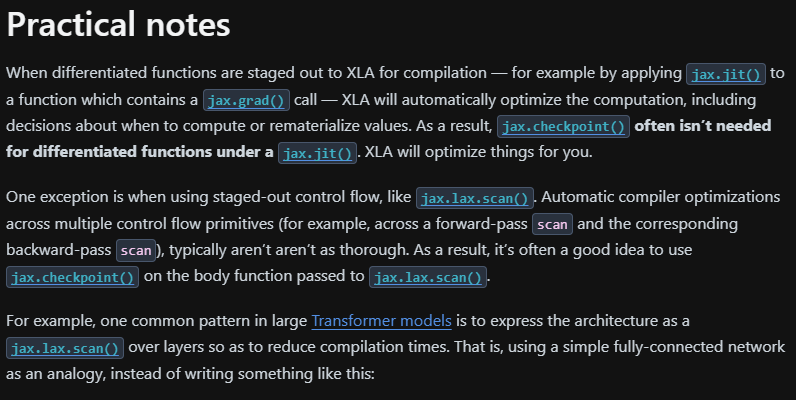

In [33]:
LayerParam = tuple[jnp.ndarray, jnp.ndarray]  # Weights-bias pair for a layer.
ParamsList = list[LayerParam]

def net(params: ParamsList, x: jnp.ndarray):
  for W, b in params:
    x = jnp.maximum(jnp.dot(x, W) + b, 0.)
  return x

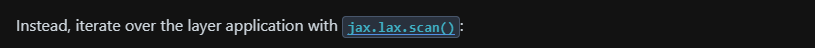

In [34]:
params = [(jnp.array([[0.5, 0.5], [1., 1.]]), jnp.array([0.5, 0.5])), 
          (jnp.array([[0.5, 0.5], [1., 1.]]), jnp.array([0.5, 0.5]))]

all_weights = jnp.stack([W for W, _ in params])
all_biases = jnp.stack([b for _, b in params])

def layer(x, W_b_pair):
  W, b = W_b_pair
  out = jnp.maximum(jnp.dot(x, W) + b, 0.)
  return out, None

def net(all_weights, all_biases, x):
  x, _ = jax.lax.scan(layer, x, (all_weights, all_biases))
  return x

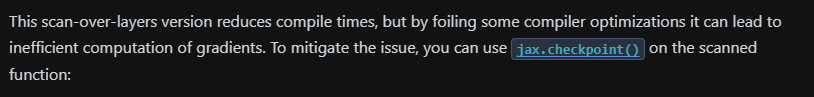

In [35]:
from functools import partial

@partial(jax.checkpoint,
         policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
def layer(x, W_b_pair):
  W, b = W_b_pair
  out = jnp.maximum(jnp.dot(x, W) + b, 0.)
  return out, None

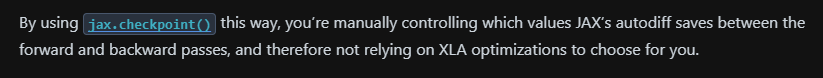